# Forward computation

Recall, to compute source estimates, one typically assumes:
    
$$M = GX + E$$

where $M \in \mathbb{R}^{C \times T}$ is the sensor data, $G \in \mathbb{R}^{C \times S}$ is the lead-field matrix, $X \in \mathbb{R}^{S \times T}$ is the source time course (stc) and $E \in \mathbb{R}^{C \times T}$ is additive Gaussian noise

The lead-field matrix or forward operator $G$ is computed using the physics of the problem. It is what we will focus on here

In [1]:
import matplotlib.pyplot as plt

import pyvista as pv
from mne.viz import set_3d_backend

set_3d_backend('notebook')
pv.set_jupyter_backend('client')

Using notebook 3d backend.



# Computing the forward operator

To compute a forward operator we need:

   - the BEM surfaces
   - a -trans.fif file that contains the coregistration info
   - a source space

In [1]:
import mne
from mne.datasets import sample

data_path = sample.data_path()

# the raw file containing the channel location + types
raw_fname = data_path / 'MEG/sample/sample_audvis_raw.fif'

# The transformation file obtained by coregistration
trans = data_path / 'MEG/sample/sample_audvis_raw-trans.fif'
# The paths to freesurfer reconstructions
subjects_dir = data_path / 'subjects'

## Compute and visualize BEM surfaces

Computing the BEM surfaces requires FreeSurfer and makes use of either of the two following command line tools:

* [mne watershed_bem](http://martinos.org/mne/dev/generated/commands.html#mne-watershed-bem)
* [mne flash_bem](http://martinos.org/mne/dev/generated/commands.html#mne-flash-bem)

Here we'll assume it's already computed. It takes a few minutes per subject.

So first look at the BEM surfaces.

For EEG we use 3 layers (inner skull, outer skull, and skin) while for MEG 1 layer (inner skull) is enough.

Using surface: /Users/mainak/mne_data/MNE-sample-data/subjects/sample/bem/inner_skull.surf
Using surface: /Users/mainak/mne_data/MNE-sample-data/subjects/sample/bem/outer_skull.surf
Using surface: /Users/mainak/mne_data/MNE-sample-data/subjects/sample/bem/outer_skin.surf


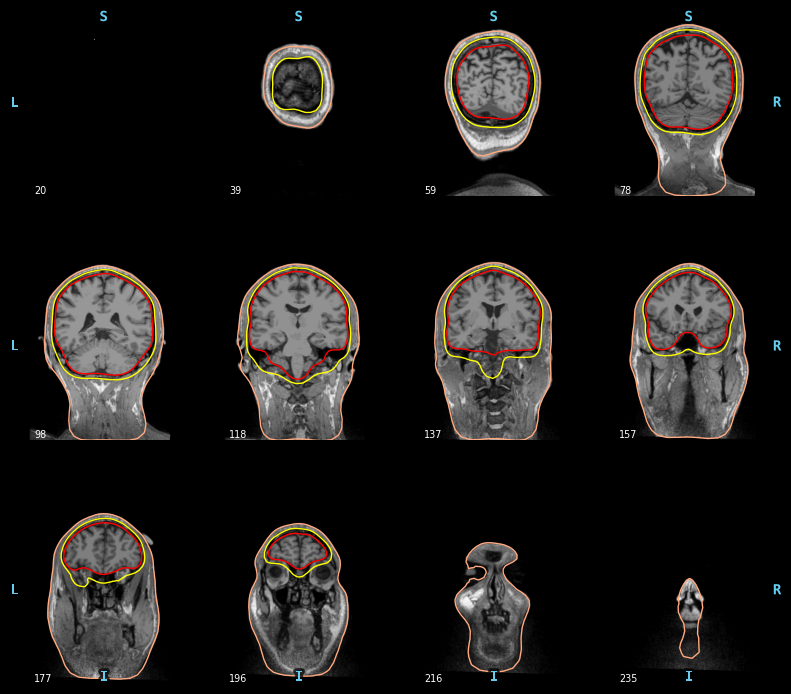

In [2]:
%matplotlib inline
mne.viz.plot_bem(subject='sample', subjects_dir=subjects_dir,
                 orientation='coronal', show=False);

In [3]:
conductivity = (0.3,)  # for single layer
# conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(subject='sample', ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
inner skull CM is   0.67 -10.01  44.26 mm
Surfaces passed the basic topology checks.
Complete.

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


### Visualization the coregistration

The coregistration is operation that allows to position the head and the sensors in a common coordinate system. In the MNE software the transformation to align the head and the sensors is stored in a so called *trans* file. It is a FIF file that ends with `-trans.fif`. 

It can be obtained with 
* mne_analyze (Unix tools)
* mne.gui.coregistration (in Python), or
* mrilab if you're using a Neuromag system.

For the Python version see http://martinos.org/mne/dev/generated/mne.gui.coregistration.html

Here we assume the coregistration is done, so we just visually check the alignment with the following code.

In [4]:
info = mne.io.read_info(raw_fname)
fig = mne.viz.plot_alignment(info, trans, subject='sample', dig=True,
                             subjects_dir=subjects_dir, verbose=True);

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
Using pyvistaqt 3d backend.

Using outer_skin.surf for head surface.
Getting helmet for system 306m
Channel types::	grad: 203, mag: 102, eeg: 59


## Compute Source Space

The source space defines the position of the candidate source locations.

The following code compute such a source space with an OCT-6 resolution.

In [5]:
subject = 'sample'
src = mne.setup_source_space(subject, spacing='oct6',
                             subjects_dir=subjects_dir,
                             add_dist=False)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/mainak/mne_data/MNE-sample-data/subjects
Subject      = sample
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /Users/mainak/mne_data/MNE-sample-data/subjects/sample/surf/lh.white...
Mapping lh sample -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mainak/mne_data/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/155407 selected to source space (oct = 6)

Loading /Users/mainak/mne_data/MNE-sample-data/subjects/sample/surf/rh.white...
Mapping rh sample -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mainak/mne_data/MNE-sample-data/subjects/sample/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/156866 selected to 

In [6]:
src

<SourceSpaces: [<surface (lh), n_vertices=155407, n_used=4098>, <surface (rh), n_vertices=156866, n_used=4098>] MRI (surface RAS) coords, subject 'sample', ~24.1 MB>

src contains two parts, one for the left hemisphere (4098 locations) and one for the right hemisphere (4098 locations).

Let's write a few lines of code to what it contains

In [7]:
import numpy as np
from mne.viz import Brain

brain = Brain('sample', 'lh', 'white', subjects_dir=subjects_dir)

surf = brain.geo['lh']
vertidx = np.where(src[0]['inuse'])[0]

src_points = np.r_[[surf.x[vertidx], surf.y[vertidx], surf.z[vertidx]]].T
brain.plotter.add_points(src_points, render_points_as_spheres=True,
                         color='y', point_size=5.);


Since it's hard to see the source points on the walls of the sulcus, it is common practice to inflate the white matter surface

In [8]:
brain = Brain('sample', 'lh', 'inflated', subjects_dir=subjects_dir)
surf = brain.geo['lh']

src_points = np.r_[[surf.x[vertidx], surf.y[vertidx], surf.z[vertidx]]].T
brain.plotter.add_points(src_points, render_points_as_spheres=True,
                         color='y', point_size=5.);

### Compute forward solution

We can now compute the forward solution.

To reduce computation we'll just compute a single layer BEM
(just inner skull) that can then be used for MEG (not EEG).

In [9]:
# Name of the forward to read (precomputed) or compute
fwd_fname = data_path / 'MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'
fwd = mne.make_forward_solution(str(raw_fname), trans=trans, src=src, bem=bem,
                                meg=True, # include MEG channels
                                eeg=False, # include EEG channels
                                mindist=5.0, # ignore sources <= 5mm from inner skull
                                n_jobs=1) # number of jobs to run in parallel

Source space          : <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=4098>, <surface (rh), n_vertices=156866, n_used=4098>] MRI (surface RAS) coords, subject 'sample', ~24.1 MB>
MRI -> head transform : /Users/mainak/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw-trans.fif
Measurement data      : sample_audvis_raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999310 0.009985 -0.035787      -3.17 mm
    0.012759 0.812405 0.582954       6.86 mm
    0.034894 -0.583008 0.811716      28.88 mm
    0.000000 0.000000 0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.991420 -0.039936 -0.124467      -6.13 mm
    0.060661 0.984012 0.167456       0.06 mm
    0.115790 -0.173570 0.977991   

In [10]:
fwd

Good channels,"203 Gradiometers, 102 Magnetometers"
Bad channels,MEG 2443
Source space,Surface with 7498 vertices
Source orientation,Free


Or read the EEG/MEG file from disk

In [14]:
fwd = mne.read_forward_solution(fwd_fname)

Reading forward solution from /Users/mainak/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame


In [13]:
fwd

Good channels,"203 Gradiometers, 102 Magnetometers, 59 EEG"
Bad channels,"MEG 2443, EEG 053"
Source space,Surface with 7498 vertices
Source orientation,Free
